### Key properties of the network
- Number of nodes
- Number of edges
- triangles 
- SCC
- degree distribution
- powerlaw
- clustering coefficient


In [1]:
import pandas as pd
from pandas import DataFrame
import numpy as np
import operator
import collections
import powerlaw


from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import networkx as nx



pd.set_option('display.max_seq_items', None)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings
warnings.filterwarnings('ignore')

### Construct the network in NetworkX

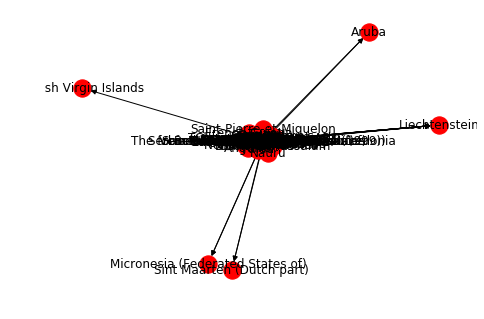

In [2]:
df = pd.read_csv("../data/unhcr_time_series_normalized.csv")
df = df[df['type']=="Refugees (incl. refugee-like situations)"]


from_to_values = df.groupby(["origin",'destination'])['value'].sum().reset_index().sort_values("value", ascending=False)
#print(from_to_values)

edge_list=from_to_values[['origin', 'destination', 'value']]
edges = list(map(tuple, list(edge_list.values)))
DG = nx.DiGraph()
DG.add_weighted_edges_from(edges)

#print(edges)
nx.draw(DG,with_labels=True)

plt.show()

In [3]:
num_nodes = len(DG)
e_max = num_nodes*(num_nodes-1)/2
num_edges = DG.number_of_edges()
deg_k = num_edges/num_nodes
print("num_nodes: ", num_nodes)
print("num_edges: ", num_edges)
print("e_max: ", e_max)
print("deg_k: ", deg_k)


num_nodes:  209
num_edges:  6552
e_max:  21736.0
deg_k:  31.349282296650717


Number of nodes will not grow in this network, because number of countries is fixed. However, we can see that E << Emax, and k << N-1. We have a sparse network, similar to most real world networks.

#### We are using a undirected graph to find triangles in the graph. Country is key and value is how many triangles the country is in

In [4]:
G = nx.Graph()
G.add_weighted_edges_from(edges)

tri = nx.triangles(G)
sorted_tri = sorted(tri.items(), key=operator.itemgetter(1), reverse=True)

print(sorted_tri)


[('Germany', 5703), ('United States of America', 5684), ('Canada', 5637), ('United Kingdom', 4541), ('Syrian Arab Rep.', 4518), ('France', 4476), ('Belgium', 4397), ('Switzerland', 4356), ('Sweden', 4350), ('Australia', 4069), ('Ukraine', 4003), ('Somalia', 4001), ('Netherlands', 3949), ('Sudan', 3948), ('Iraq', 3916), ('Turkey', 3906), ('Russian Federation', 3843), ('Ethiopia', 3796), ('Egypt', 3707), ('Dem. Rep. of the Congo', 3672), ('Nigeria', 3659), ('Italy', 3571), ('Ireland', 3459), ('Eritrea', 3349), ('Cameroon', 3322), ("Côte d'Ivoire", 3298), ('Pakistan', 3178), ('Liberia', 3177), ('Norway', 3067), ('Brazil', 3063), ('Austria', 3004), ('Argentina', 2981), ('Iran (Islamic Rep. of)', 2955), ('Afghanistan', 2847), ('Romania', 2833), ('Rwanda', 2786), ('South Africa', 2777), ('Congo', 2776), ('State of Palestine', 2744), ('Uganda', 2718), ('Morocco', 2633), ('Yemen', 2613), ('Hungary', 2588), ('Burundi', 2577), ('Finland', 2569), ('Ecuador', 2546), ('Poland', 2516), ('Spain', 250

In [5]:
strongly_connected_components = nx.strongly_connected_components(DG)
core_components = [c for c in sorted(strongly_connected_components, key=len, reverse=True) if len(c) > 1]
print("Num Strongly Connected Components = %s" % (len(core_components)))
print(core_components)

Num Strongly Connected Components = 1
[{'Mauritania', 'Yemen', 'Cuba', 'Lebanon', 'Peru', 'Slovenia', 'Guinea-Bissau', 'Israel', 'Japan', 'Trinidad and Tobago', 'Bahrain', 'Djibouti', 'Egypt', 'Grenada', 'Serbia and Kosovo (S/RES/1244 (1999))', 'Zambia', 'Venezuela (Bolivarian Republic of)', 'Sweden', 'Czech Rep.', 'Central African Rep.', 'Seychelles', 'Syrian Arab Rep.', 'Pakistan', 'Qatar', 'Lesotho', 'Malta', 'Guyana', 'New Zealand', 'Bolivia (Plurinational State of)', 'Denmark', 'Antigua and Barbuda', 'Haiti', 'Mauritius', 'Nicaragua', 'Nauru', 'Belarus', 'Rep. of Moldova', 'Kenya', 'Rep. of Korea', 'Suriname', 'Mexico', 'Malawi', 'Canada', 'Cameroon', 'Mali', 'Afghanistan', 'Morocco', 'Burundi', 'Mongolia', 'Honduras', 'Thailand', 'Kyrgyzstan', 'China', 'Belgium', 'Namibia', 'Saint Lucia', 'Norway', 'Timor-Leste', 'Portugal', 'Panama', 'Uganda', 'Iraq', 'Belize', 'Uzbekistan', 'Palau', 'Tunisia', 'Philippines', 'Malaysia', 'Ghana', 'Algeria', 'Swaziland', 'Cayman Islands', 'Oman',

We found one SCC but it appears to contain all nodes. We need to identify a meaningful way to draw links between countries instead of drawing all edges 

### Degree Distribution
We examine inflow and outflow of nodes by summing the edge weights. In our case, this means we examine the distribution of refugees based on their origin and desintations

In [6]:
inflow = df.groupby(['destination'])['value'].sum().reset_index().sort_values("value", ascending=False)
inflow_values = inflow.value.tolist()


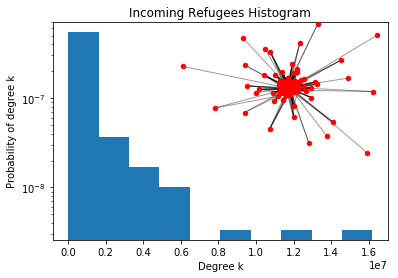

In [7]:
plt.hist(inflow_values, density=True, log=True)
plt.title("Incoming Refugees Histogram")
plt.ylabel("Probability of degree k")
plt.xlabel("Degree k")

# draw graph in inset
plt.axes([0.4, 0.4, 0.5, 0.5])
Gcc = sorted(nx.connected_component_subgraphs(G), key=len, reverse=True)[0]
pos = nx.spring_layout(G)
plt.axis('off')
nx.draw_networkx_nodes(G, pos, node_size=20)
nx.draw_networkx_edges(G, pos, alpha=0.4)

plt.show()


- This now represents what we were trying to achieve with power law. We should instead consider when to draw edges between two countries, so we analyze degrees instead of flow 

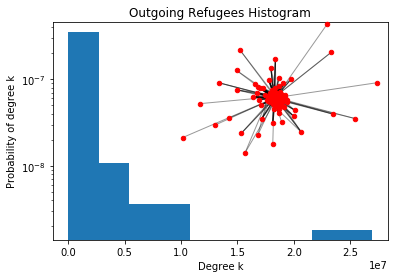

In [8]:
outflow = df.groupby(['origin'])['value'].sum().reset_index().sort_values("value", ascending=False)
outflow_values = outflow.value.tolist()

plt.hist(outflow_values, density=True, log=True)
plt.title("Outgoing Refugees Histogram")
plt.ylabel("Probability of degree k")
plt.xlabel("Degree k")

# draw graph in inset
plt.axes([0.4, 0.4, 0.5, 0.5])
Gcc = sorted(nx.connected_component_subgraphs(G), key=len, reverse=True)[0]
pos = nx.spring_layout(G)
plt.axis('off')
nx.draw_networkx_nodes(G, pos, node_size=20)
nx.draw_networkx_edges(G, pos, alpha=0.4)

plt.show()


#### Powerlaw graphs for incoming and outgoing refugees based on number of refugees.

<Figure size 1296x576 with 0 Axes>

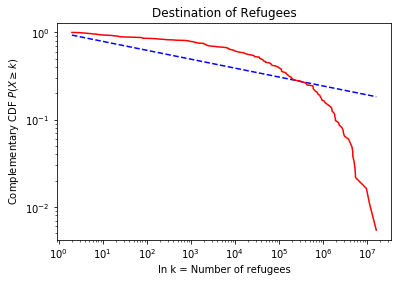

alpha=  1.1021465933371803   sigma=  0.007530346768096326


In [9]:
plt.figure(figsize=(18,8));

#lables = [r'$x^{-( \alpha-1)}, \alpha = 1.11$', "Empirical data"]


fit = powerlaw.Fit(np.array(inflow_values)+1,xmin=1,discrete=False)
fit.power_law.plot_ccdf( color= 'b',linestyle='--',label='fit ccdf')
fit.plot_ccdf( color= 'r')
plt.title('Destination of Refugees')
plt.xlabel('In k = Number of refugees')
plt.ylabel('Complementary CDF '+ r'$P(X\geq k)$')
#plt.legend(lables, loc='best', fontsize = 'small')

plt.show()
print('alpha= ',fit.power_law.alpha,'  sigma= ',fit.power_law.sigma)

<Figure size 1296x576 with 0 Axes>

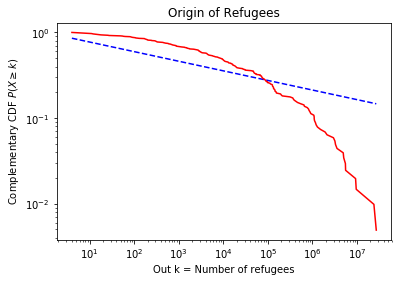

alpha=  1.1121860211128676   sigma=  0.007854592553534713


In [10]:
plt.figure(figsize=(18,8));

#lables = [r'$x^{-( \alpha-1)}, \alpha = 1.11$', "Empirical data"]


fit = powerlaw.Fit(np.array(outflow_values)+1,xmin=1,discrete=False)
fit.power_law.plot_ccdf( color= 'b',linestyle='--',label='fit ccdf')
fit.plot_ccdf( color= 'r')
plt.title('Origin of Refugees')
plt.xlabel('Out k = Number of refugees')
plt.ylabel('Complementary CDF '+ r'$P(X\geq k)$')
#plt.legend(lables, loc='best', fontsize = 'small')

plt.show()
print('alpha= ',fit.power_law.alpha,'  sigma= ',fit.power_law.sigma)

#### Clustering coefficient
This would indicate the amount of refugee movements around a certain country. How much are refugees moving around among the country's neighbors? 

In [11]:
print(nx.average_clustering(DG, weight=True))

0.4185289701656351


In [12]:
to_from_values = df.groupby(["destination", 'origin'])['value'].sum().reset_index().sort_values("value", ascending=False)
edge_list_out = to_from_values[["destination", 'origin', 'value']]
edges_out = list(map(tuple, list(edge_list_out.values)))
DG_out = nx.DiGraph()
DG_out.add_weighted_edges_from(edges_out)

print(nx.average_clustering(DG_out, weight=True))

0.4185289701656351


Notice direction of the graph did not matter for avg clustering coefficient

In [13]:
cc = nx.clustering(DG, weight=True)
sorted_cc = sorted(cc.items(), key=operator.itemgetter(1), reverse=True)
print(sorted_cc)

[('Monaco', 1.0), ('San Marino', 1.0), ('Tuvalu', 1.0), ('Anguilla', 1.0), ('Aruba', 1.0), ('Saint Vincent and the Grenadines', 0.8), ('Dominica', 0.7666666666666667), ('Kiribati', 0.75), ('Andorra', 0.75), ('Barbados', 0.7), ('Saint Kitts and Nevis', 0.7), ('Seychelles', 0.6964285714285714), ('Saint Lucia', 0.6904761904761905), ('Antigua and Barbuda', 0.6904761904761905), ('Samoa', 0.6666666666666666), ('Tonga', 0.65), ('Qatar', 0.6490384615384616), ('Maldives', 0.6454545454545455), ('Oman', 0.6263736263736264), ('Belize', 0.6181818181818182), ('Grenada', 0.6071428571428571), ('Cayman Islands', 0.6), ('Mauritius', 0.5714285714285714), ('Singapore', 0.5705128205128205), ('Solomon Islands', 0.5666666666666667), ('Timor-Leste', 0.5666666666666667), ('Vanuatu', 0.5666666666666667), ('Malawi', 0.5629067245119306), ('Lesotho', 0.5541666666666667), ('Bahrain', 0.5526315789473685), ('Turks and Caicos Islands', 0.55), ('Djibouti', 0.547741935483871), ('Botswana', 0.5476923076923077), ('Bahamas